In [172]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

### Protocolo experimental:
1. Separar os datasets em teste, treino e validação. Onde a validação representa os últimos 30 dias e não há embaralhamento na separação, o teste terá 20% do tamanho do treino.
2. Realizar a implementação no modelo com diferentes atributos, comparando as taxas de erro para escolher o de melhor desempenho.
3.Tentar melhorar a dependência temporal do modelos adicionando novos atributos

In [173]:
sjc = pd.read_csv('../Normalizados/dados/3549904.csv').drop(columns=['Unnamed: 0'])
tam = 30
sjc = sjc.set_index(['data'])
sjc.index = pd.to_datetime(sjc.index)
sjc = sjc.drop(columns=['Município', 'Código IBGE', 'Populacao', 'Total 1ª Dose'])

val = sjc[sjc.shape[0]-tam-1:]

sjc = sjc[:-tam]

test_ratio = 0.2
X = sjc.drop(columns=['obito', 'diagnostico_covid19'])
y = pd.DataFrame(data=[])
y['diagnostico_covid19'] = sjc['diagnostico_covid19']

val_ratio = test_ratio / (1 - test_ratio)
sjc

,Total 2ª Dose,Total Unica,Total Doses Aplicadas,População Vacinada dose1/População Total,População Vacinada/População Total,diagnostico_covid19,obito,media_movel_casos,media_movel_obitos,ocupacao_leitos,media_isolamento,Mean.R
data,,,,,,,,,,,,
2021-02-21,0.002049,0.0,0.000000,0.000000,0.001787,0.162562,0.235294,0.155941,0.189873,0.167532,0.539216,0.0
2021-02-22,0.000835,0.0,0.012848,0.017281,0.000729,0.315271,0.235294,0.172277,0.215190,0.164937,0.294118,0.0
2021-02-23,0.000835,0.0,0.027152,0.036145,0.000729,0.248768,0.235294,0.178218,0.240506,0.179642,0.269608,0.0
2021-02-24,0.001054,0.0,0.040485,0.053667,0.000919,0.201970,0.294118,0.180693,0.291139,0.161188,0.411765,0.0
2021-02-25,0.001064,0.0,0.047152,0.062456,0.000928,0.229064,0.176471,0.172277,0.291139,0.152249,0.264706,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-15,0.892542,0.0,0.672597,0.638973,0.778477,0.482759,0.235294,0.556931,0.265823,0.772780,0.352941,0.0
2021-06-16,0.895058,0.0,0.693687,0.666085,0.780672,0.426108,0.117647,0.529208,0.253165,0.763841,0.352941,0.0
2021-06-17,0.896232,0.0,0.717098,0.696632,0.781696,0.443350,0.058824,0.496535,0.189873,0.738754,0.352941,0.0


In [174]:
#testando atributos

menor = 99

for i in range(10, 0, -1):
    sel = SelectKBest(mutual_info_regression, k=i)
    X_sel = sel.fit_transform(X, y['diagnostico_covid19'])
    X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=test_ratio, shuffle=False)
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_train, y_train)
    
    y_pred = neigh.predict(X_test)

    pred = []
    for k in y_pred:
        pred.append(k[0])
    y_test.insert(1, 'pred', pred, True)
    
    comparacao = y_test.copy() 
    y_pred = y_test[['pred']].copy()
    y_test = y_test.drop(columns='pred')
    erro = mean_squared_error(y_test.values, y_pred)
    if erro <= menor:
        menor = erro
        resul = X_sel
    print("Erro com k = {} -> {}" .format(i, erro))

print(resul)

Erro com k = 10 -> 0.04148180615884881
Erro com k = 9 -> 0.04148180615884881
Erro com k = 8 -> 0.04148180615884881
Erro com k = 7 -> 0.04673622064759319
Erro com k = 6 -> 0.04492092140066493
Erro com k = 5 -> 0.028327893583116947
Erro com k = 4 -> 0.0295999660268388
Erro com k = 3 -> 0.03675512832957201
Erro com k = 2 -> 0.0355684336754916
Erro com k = 1 -> 0.0355684336754916
[[2.04871160e-03 0.00000000e+00 0.00000000e+00 1.78689150e-03
  1.55940594e-01]
 [8.35396963e-04 1.28481142e-02 1.72814474e-02 7.28635370e-04
  1.72277228e-01]
 [8.35396963e-04 2.71518018e-02 3.61445116e-02 7.28635370e-04
  1.78217822e-01]
 [1.05419141e-03 4.04851072e-02 5.36669409e-02 9.19468443e-04
  1.80693069e-01]
 [1.06413661e-03 4.71517598e-02 6.24558546e-02 9.28142674e-04
  1.72277228e-01]
 [1.06413661e-03 5.18419411e-02 6.86410561e-02 9.28142674e-04
  1.73762376e-01]
 [1.06413661e-03 5.72924653e-02 7.58289638e-02 9.28142674e-04
  1.61881188e-01]
 [1.06413661e-03 5.72924653e-02 7.58289638e-02 9.28142674e-04

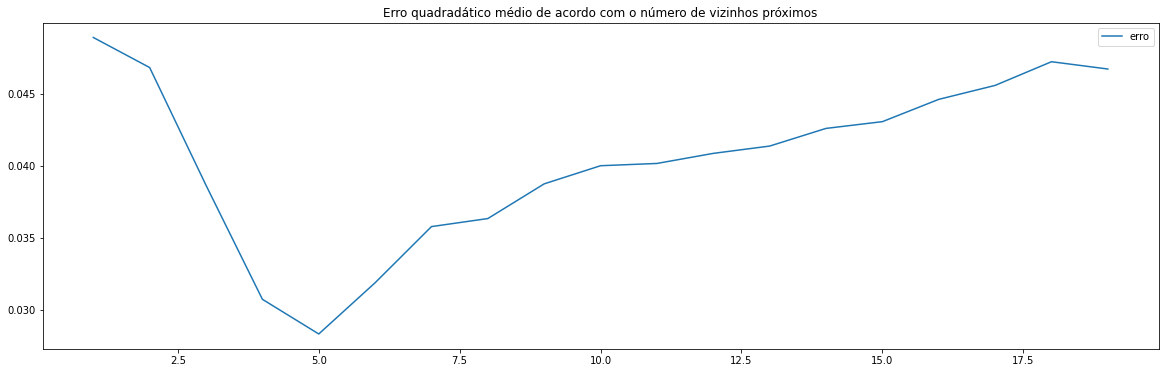

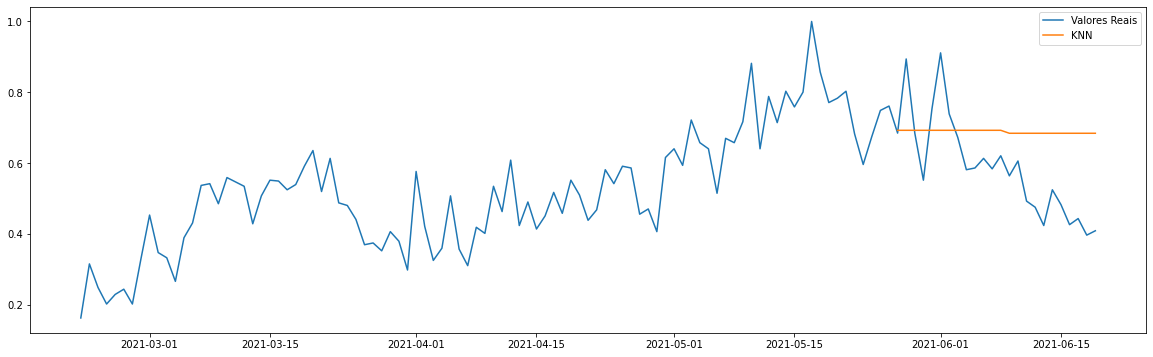

0.028327893583116947


,diagnostico_covid19,pred
data,,
2021-05-27,0.684729,0.692611
2021-05-28,0.894089,0.692611
2021-05-29,0.684729,0.692611
2021-05-30,0.551724,0.692611
2021-05-31,0.753695,0.692611
2021-06-01,0.911330,0.692611
2021-06-02,0.738916,0.692611
2021-06-03,0.672414,0.692611
2021-06-04,0.581281,0.692611


In [175]:
X = X[['Total 2ª Dose', 'Total Doses Aplicadas', 'População Vacinada dose1/População Total', 'População Vacinada/População Total', 'media_movel_casos']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

erros_knear = []
qtd_k = []

for k in range(1,20):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)

    pred = []
    for i in y_pred:
        pred.append(i[0])
    y_test.insert(1, 'pred', pred, True)

    comparacao = y_test.copy() 
    y_pred = y_test[['pred']].copy()
    y_test = y_test.drop(columns='pred')
    erro = mean_squared_error(y_test.values, y_pred)
    erros_knear.append(erro)
    qtd_k.append(k)
    if(k == 1):
        menor_erro = erro
        nk = k
    elif(erro < menor_erro):
        menor_erro = erro
        nk = k

plt.figure(figsize=(20, 6))
plt.plot(qtd_k, erros_knear, label='erro')
plt.legend()
plt.title('Erro quadradático médio de acordo com o número de vizinhos próximos')
plt.show()

neigh = KNeighborsRegressor(n_neighbors=nk)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

pred = []
for i in y_pred:
    pred.append(i[0])
y_test.insert(1, 'pred', pred, True)

comparacao = y_test.copy() 
y_pred = y_test[['pred']].copy()
y_test = y_test.drop(columns='pred')
erro = mean_squared_error(y_test.values, y_pred)



plt.figure(figsize=(20, 6))
plt.plot(y,label='Valores Reais')
plt.plot(y_pred, label='KNN')
plt.legend()
plt.show()
print(erro)
comparacao

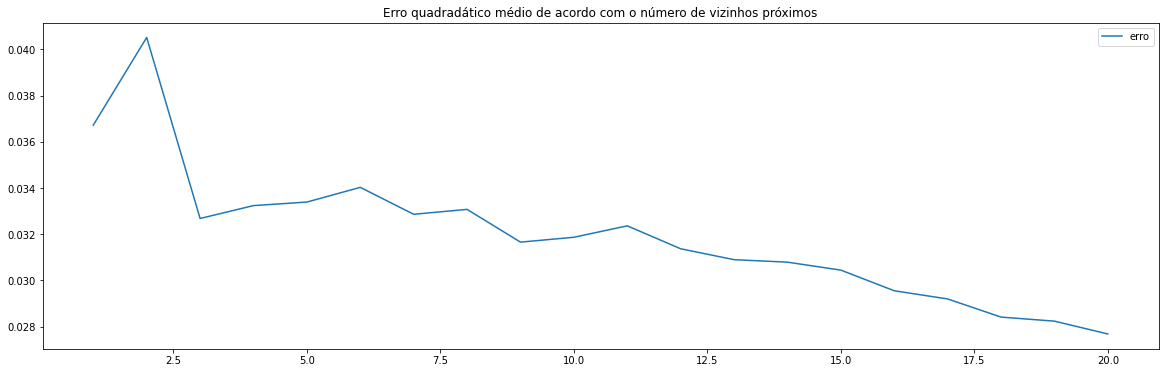

Numero de vizinhos próximos com erro mínimo: 20


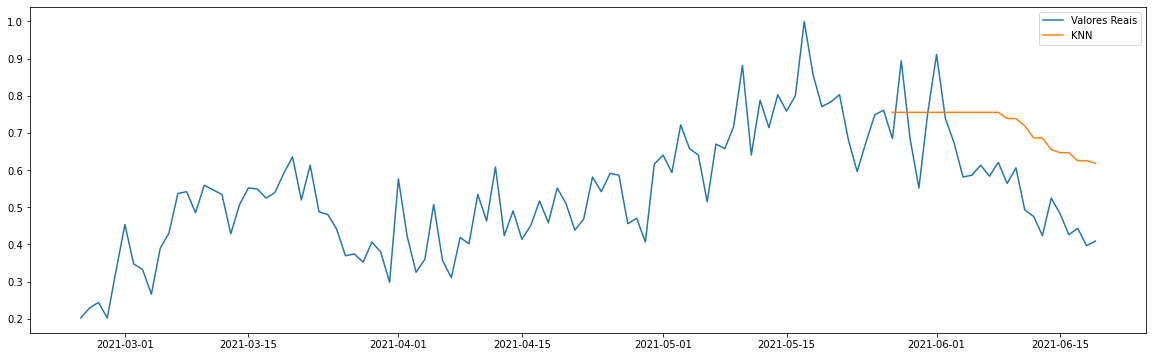

0.027684181170982064


,diagnostico_covid19,pred
data,,
2021-05-27,0.684729,0.755419
2021-05-28,0.894089,0.755419
2021-05-29,0.684729,0.755419
2021-05-30,0.551724,0.755419
2021-05-31,0.753695,0.755419
2021-06-01,0.911330,0.755419
2021-06-02,0.738916,0.755419
2021-06-03,0.672414,0.755419
2021-06-04,0.581281,0.755419


In [176]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["media_movel_casos"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

X = X[['Total 2ª Dose', 'Total Doses Aplicadas', 'População Vacinada dose1/População Total', 'População Vacinada/População Total', 'media_movel_casos']]
X = generate_time_lags(X, 3)
y = y[3:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

#obtendo o k mínimo para KnearestNeighbors
erros_knear = []
qtd_k = []

for k in range(1,21):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)

    pred = []
    for i in y_pred:
        pred.append(i[0])
    y_test.insert(1, 'pred', pred, True)

    comparacao = y_test.copy() 
    y_pred = y_test[['pred']].copy()
    y_test = y_test.drop(columns='pred')
    erro = mean_squared_error(y_test.values, y_pred)
    erros_knear.append(erro)
    qtd_k.append(k)
    if(k == 1):
        menor_erro = erro
        nk = k
    elif(erro < menor_erro):
        menor_erro = erro
        nk = k

plt.figure(figsize=(20, 6))
plt.plot(qtd_k, erros_knear, label='erro')
plt.legend()
plt.title('Erro quadradático médio de acordo com o número de vizinhos próximos')
plt.show()
print(f'Numero de vizinhos próximos com erro mínimo: {nk}')

neigh = KNeighborsRegressor(n_neighbors=nk)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

pred = []
for i in y_pred:
    pred.append(i[0])
y_test.insert(1, 'pred', pred, True)

comparacao = y_test.copy() 
y_pred = y_test[['pred']].copy()
y_test = y_test.drop(columns='pred')
erro = mean_squared_error(y_test.values, y_pred)



plt.figure(figsize=(20, 6))
plt.plot(y,label='Valores Reais')
plt.plot(y_pred, label='KNN')
plt.legend()
plt.show()
print(erro)
comparacao


1 -> 0.0327507220560638
2 -> 0.029382837335290832
3 -> 0.027684181170982064
4 -> 0.028030615673866097
5 -> 0.028968975223858863
6 -> 0.029995426943460003
7 -> 0.031063493807283547
8 -> 0.03263489626580094
9 -> 0.03782115529705558
10 -> 0.03861243075762354
11 -> 0.04087196654415739
12 -> 0.04224352745097606
13 -> 0.04398658018769069
14 -> 0.047119455094760856
15 -> 0.04892860176175106
16 -> 0.05007947076401479
17 -> 0.05223386607063411
18 -> 0.05334611226858671
19 -> 0.049197700289985206
20 -> 0.04945393679172026
21 -> 0.04961132959426341
22 -> 0.04971362293431048
23 -> 0.05067977717246234
24 -> 0.05539762009065469
25 -> 0.05572874346559449
26 -> 0.05581569192856439
27 -> 0.05544203584807098
28 -> 0.055510332598525336
29 -> 0.060122462629522665
0.027684181170982064


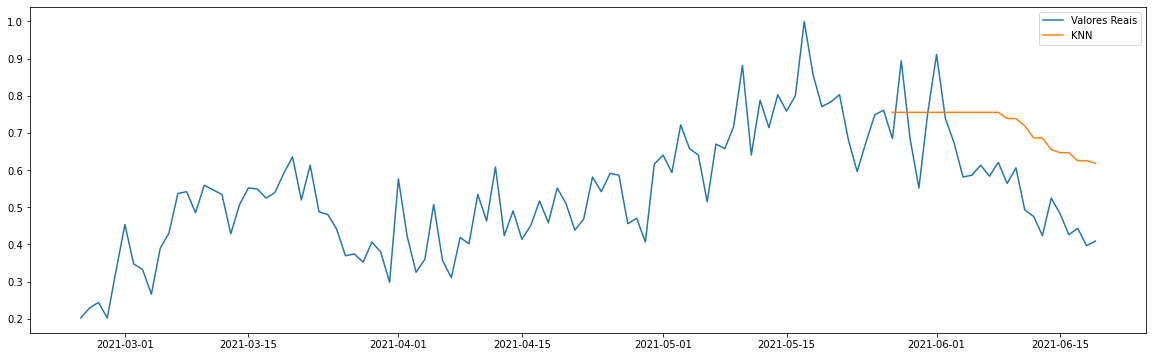

,diagnostico_covid19,pred
data,,
2021-05-27,0.684729,0.755419
2021-05-28,0.894089,0.755419
2021-05-29,0.684729,0.755419
2021-05-30,0.551724,0.755419
2021-05-31,0.753695,0.755419
2021-06-01,0.911330,0.755419
2021-06-02,0.738916,0.755419
2021-06-03,0.672414,0.755419
2021-06-04,0.581281,0.755419


In [177]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["media_movel_casos"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

for lag in range(1, 30):
    
    X = sjc.drop(columns=['obito', 'diagnostico_covid19'])
    y = pd.DataFrame(data=[])
    y['diagnostico_covid19'] = sjc['diagnostico_covid19']
    
    X = X[['Total 2ª Dose', 'Total Doses Aplicadas', 'População Vacinada dose1/População Total', 'População Vacinada/População Total', 'media_movel_casos']]
    X = generate_time_lags(X, lag)
    y = y[lag:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

    neigh = KNeighborsRegressor(n_neighbors=20)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)

    pred = []
    for i in y_pred:
        pred.append(i[0])
    y_test.insert(1, 'pred', pred, True)

    comparacao = y_test.copy() 
    y_pred = y_test[['pred']].copy()
    y_test = y_test.drop(columns='pred')
    erro = mean_squared_error(y_test.values, y_pred)
    print(f'{lag} -> {erro}')
    if(lag == 1):
        menor_erro = erro
        nlag = lag
    elif(erro < menor_erro):
        menor_erro = erro
        nlag = lag

X = sjc.drop(columns=['obito', 'diagnostico_covid19'])
y = pd.DataFrame(data=[])
y['diagnostico_covid19'] = sjc['diagnostico_covid19']

X = X[['Total 2ª Dose', 'Total Doses Aplicadas', 'População Vacinada dose1/População Total', 'População Vacinada/População Total', 'media_movel_casos']]
X = generate_time_lags(X, nlag)
y = y[nlag:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

neigh = KNeighborsRegressor(n_neighbors=20)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

pred = []
for i in y_pred:
    pred.append(i[0])
y_test.insert(1, 'pred', pred, True)

comparacao = y_test.copy() 
y_pred = y_test[['pred']].copy()
y_test = y_test.drop(columns='pred')
erro = mean_squared_error(y_test.values, y_pred)
print(erro)
plt.figure(figsize=(20, 6))
plt.plot(y,label='Valores Reais')
plt.plot(y_pred, label='KNN')
plt.legend()
plt.show()
comparacao
